In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (48).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (68).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (89).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (73).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (38).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (81).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (67).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (94).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Datacluster Fire and Smoke Sample (29).xml
/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations/Dat

In [2]:
!pip install -q ultralytics

import os
from pathlib import Path
import random
import shutil
import xml.etree.ElementTree as ET


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [3]:
images_dir = "/kaggle/input/fire-and-smoke-dataset/Datacluster Fire and Smoke Sample/Datacluster Fire and Smoke Sample"
annotations_dir = "/kaggle/input/fire-and-smoke-dataset/Annotations/Annotations"
output_labels_dir = "/kaggle/working/fire_and_smoke/labels"

os.makedirs(output_labels_dir, exist_ok=True)

In [4]:
class_map = {"fire": 0, "smoke": 1}

In [5]:
# XML to YOLO conversion
def convert_xml_to_yolo(xml_file, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    image_w = int(size.find('width').text)
    image_h = int(size.find('height').text)

    label_lines = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower()
        class_id = class_map.get(name, -1)
        if class_id == -1:
            continue

        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2) / image_w
        y_center = ((ymin + ymax) / 2) / image_h
        width = (xmax - xmin) / image_w
        height = (ymax - ymin) / image_h

        label_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    filename = os.path.splitext(os.path.basename(xml_file))[0] + ".txt"
    with open(os.path.join(output_dir, filename), "w") as f:
        f.write("\n".join(label_lines))

# Convert all XMLs
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        convert_xml_to_yolo(os.path.join(annotations_dir, xml_file), output_labels_dir)

In [6]:
# 3️⃣ Create train/val split directories
Path('yolo_dataset/images/train').mkdir(parents=True, exist_ok=True)
Path('yolo_dataset/labels/train').mkdir(parents=True, exist_ok=True)
Path('yolo_dataset/images/val').mkdir(parents=True, exist_ok=True)
Path('yolo_dataset/labels/val').mkdir(parents=True, exist_ok=True)
# Split files
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random.shuffle(image_files)
split_index = int(0.8 * len(image_files))
train_files = image_files[:split_index]
val_files = image_files[split_index:]

In [7]:
# Move train files
for img_file in train_files:
    label_file = img_file.replace('.jpg', '.txt')
    shutil.copy(os.path.join(images_dir, img_file), f'yolo_dataset/images/train/{img_file}')
    if os.path.exists(os.path.join(output_labels_dir, label_file)):
        shutil.copy(os.path.join(output_labels_dir, label_file), f'yolo_dataset/labels/train/{label_file}')

# Move val files
for img_file in val_files:
    label_file = img_file.replace('.jpg', '.txt')
    shutil.copy(os.path.join(images_dir, img_file), f'yolo_dataset/images/val/{img_file}')
    if os.path.exists(os.path.join(output_labels_dir, label_file)):
        shutil.copy(os.path.join(output_labels_dir, label_file), f'yolo_dataset/labels/val/{label_file}')

In [8]:
# 4️⃣ Create data.yaml for YOLOv8
data_yaml = """
path: /kaggle/working/yolo_dataset
train: images/train
val: images/val

names:
  0: fire
  1: smoke
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as f:
    f.write(data_yaml)


In [9]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Use 'yolov8s.pt' for a bigger model
model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=100, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.0MB/s]


Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1451.6±784.5 MB/s, size: 134.7 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:01<00:00, 48.21it/s]


train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (22).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (23).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (26).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (29).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (31).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (32).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (41).jpg: corrupt JPEG restored and saved
train: /kaggle/working/yolo_dataset/images/train/Datacluster Fire and Smoke Sample (42).jpg: corrupt JPEG restored and saved


val: Scanning /kaggle/working/yolo_dataset/labels/val... 20 images, 1 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 64.98it/s]

val: /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (24).jpg: corrupt JPEG restored and saved
val: /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (40).jpg: corrupt JPEG restored and saved
val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.05G      1.832      3.954      1.802         35        640: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

                   all         20         23     0.0049      0.522      0.029    0.00994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100      2.17G      1.656      3.736      1.704         40        640: 100%|██████████| 5/5 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         20         23    0.00583      0.696      0.177      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.18G      1.396       3.32      1.506         31        640: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         20         23     0.0071      0.783      0.268      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.18G      1.437      2.749      1.511         31        640: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         20         23    0.00848      0.783      0.313      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.19G      1.432      2.405      1.397         49        640: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         20         23    0.00705      0.652      0.354      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.19G      1.301      2.391      1.374         36        640: 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         20         23    0.00687      0.696      0.396      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.19G      1.334       2.22      1.358         43        640: 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20         23     0.0897      0.522      0.374      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.19G      1.251      2.061      1.336         39        640: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         20         23    0.00692      0.609      0.344      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.19G      1.261      1.938       1.34         33        640: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         20         23      0.767      0.174      0.256       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.19G      1.322      2.084      1.375         26        640: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


                   all         20         23      0.883       0.13      0.207      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.19G      1.314      2.069       1.33         40        640: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         20         23      0.541      0.206      0.265      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.19G      1.326      1.942      1.338         34        640: 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         20         23      0.508      0.304      0.336      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.19G      1.287      1.982       1.33         34        640: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         20         23      0.515      0.324       0.37      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.19G      1.229      1.818      1.276         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         20         23      0.573      0.261      0.312      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.19G      1.206      1.752      1.241         41        640: 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         20         23       0.59      0.348      0.356      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.19G      1.177      1.919      1.323         34        640: 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         20         23      0.424      0.217      0.177      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.19G      1.222      1.926      1.359         40        640: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         20         23      0.261       0.13      0.137     0.0596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.19G      1.232      1.846      1.322         43        640: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


                   all         20         23      0.346      0.217      0.189     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.19G      1.157       1.74      1.235         25        640: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         20         23      0.343      0.391       0.31      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.19G      1.156      1.639      1.246         41        640: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         20         23      0.413      0.217       0.22     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.19G      1.164       1.54        1.2         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         20         23      0.322      0.217      0.135     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.19G      1.178      1.687      1.197         38        640: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         20         23      0.346      0.217      0.166     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.19G      1.227      1.521      1.273         45        640: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         20         23      0.254      0.435      0.249     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.19G      1.172      1.573      1.266         42        640: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         20         23      0.275      0.391      0.178     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.19G      1.173      1.515      1.269         45        640: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         20         23      0.128      0.348      0.137     0.0644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.19G      1.185      1.584      1.266         45        640: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         20         23      0.223      0.348       0.18     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.19G       1.16      1.595      1.262         35        640: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         20         23      0.422      0.304      0.297      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.19G      1.157      1.496      1.292         48        640: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         20         23      0.435      0.478      0.352      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.19G      1.076      1.409      1.202         45        640: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         20         23      0.232      0.447      0.241      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.19G      1.083      1.396      1.216         42        640: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         20         23      0.177      0.435      0.134     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.19G      1.051      1.376      1.191         33        640: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         20         23      0.403      0.522        0.4      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.19G      1.069       1.36      1.201         40        640: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


                   all         20         23      0.596      0.386      0.348      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.19G      1.061      1.255      1.202         35        640: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         20         23      0.744      0.391      0.436      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.19G     0.9724      1.233        1.1         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         20         23      0.634      0.391      0.424      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.19G     0.9745      1.223      1.164         34        640: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         20         23      0.476      0.554      0.464      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.19G     0.9654      1.163      1.118         36        640: 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         20         23      0.403      0.478      0.391      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.19G      1.037       1.19      1.167         41        640: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         20         23      0.499      0.304      0.339      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.19G     0.9921      1.301      1.142         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         20         23      0.407      0.391      0.318      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.19G       1.06      1.289      1.206         31        640: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20         23      0.448      0.304      0.282      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.19G     0.9855      1.183      1.145         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         23      0.691      0.435      0.473      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.19G      1.039      1.218      1.149         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         20         23      0.552      0.483      0.489      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.19G      1.011      1.113      1.148         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         20         23      0.739      0.565      0.612      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.19G     0.9072      1.052      1.114         35        640: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]

                   all         20         23      0.583      0.652      0.605      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.19G     0.9054      1.056      1.075         51        640: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20         23      0.889      0.478      0.686      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.19G     0.8738      1.016      1.065         52        640: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         20         23      0.687      0.478      0.585      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.19G     0.8956      1.057      1.098         36        640: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         20         23      0.691      0.522      0.572      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.19G     0.8647     0.9736      1.056         43        640: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         20         23      0.703      0.522       0.57      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.19G     0.9199     0.9957      1.106         38        640: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         20         23      0.744      0.522      0.551      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.19G     0.9772       1.01      1.129         42        640: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         20         23      0.748      0.522      0.596      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.19G     0.8861     0.9939      1.085         42        640: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         20         23      0.649      0.652      0.669      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.19G     0.8735     0.9841      1.046         29        640: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         20         23      0.804      0.609      0.694      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.19G     0.8136     0.8944      1.021         35        640: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


                   all         20         23      0.976      0.696      0.813      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.19G     0.8971     0.9666        1.1         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20         23      0.872      0.609      0.734      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.19G     0.8365     0.9647      1.034         34        640: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         20         23      0.839      0.522      0.686      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.19G     0.8956     0.9228      1.075         35        640: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         20         23      0.705      0.565      0.613      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.19G     0.8575     0.8941      1.044         44        640: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20         23      0.756      0.565      0.614      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.19G     0.8546     0.9143      1.074         39        640: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         20         23      0.865      0.558      0.646      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.19G     0.8714     0.8756      1.022         38        640: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20         23      0.807      0.522      0.656      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.19G     0.8274     0.9248      1.077         44        640: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         20         23      0.812      0.565       0.65      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.19G     0.7525     0.8071     0.9917         33        640: 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         23      0.728      0.522      0.593      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.19G     0.8275     0.8569      1.088         51        640: 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         20         23      0.837      0.522      0.677      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.19G     0.7713     0.8475      1.039         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         20         23      0.822      0.478      0.673      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.19G     0.7818     0.8099      1.012         30        640: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         20         23      0.914      0.609      0.781      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.19G     0.7801     0.8092      1.039         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         20         23      0.746       0.64      0.731      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.19G     0.8287     0.8414      1.051         48        640: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20         23      0.738      0.609      0.735      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.19G     0.8488     0.8587      1.034         50        640: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         20         23      0.825      0.696      0.742       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.19G      0.793     0.8203      1.042         37        640: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


                   all         20         23      0.805      0.739      0.799      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.19G     0.7668     0.8141      1.013         44        640: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         20         23      0.824      0.812      0.769      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.19G     0.7763     0.8075      1.017         39        640: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


                   all         20         23      0.799      0.826      0.821      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.19G      0.729     0.7673     0.9713         47        640: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         20         23       0.77      0.783      0.785      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.19G     0.7464     0.7501      1.025         30        640: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         20         23      0.809      0.739      0.808      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.19G     0.7447     0.7934      1.017         39        640: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         20         23      0.843      0.783      0.816      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.19G     0.7528     0.7981      1.021         50        640: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         23      0.872      0.696      0.801      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.19G     0.7219     0.7545     0.9719         50        640: 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         23      0.767      0.696      0.792      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.19G     0.7312     0.7896      1.015         36        640: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all         20         23      0.808      0.652      0.784      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.19G     0.7341     0.7884      1.046         49        640: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]

                   all         20         23      0.773      0.739      0.794      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.19G     0.7693     0.7656      1.024         36        640: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         20         23      0.832      0.696      0.811      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.19G     0.6892     0.7235     0.9877         35        640: 100%|██████████| 5/5 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


                   all         20         23      0.817      0.652      0.785      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.19G     0.7401     0.7494      1.042         21        640: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         20         23      0.754      0.609      0.739      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.19G     0.7096     0.7651     0.9733         30        640: 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         20         23      0.805      0.565      0.743      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.19G     0.6641     0.6436     0.9546         43        640: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         20         23      0.617      0.609      0.712      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.19G     0.7352     0.6858      0.999         49        640: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20         23      0.727      0.565      0.702      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.19G     0.7018      0.702      1.038         38        640: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         20         23      0.718      0.553      0.688      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.19G     0.6848     0.7011     0.9868         40        640: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         23      0.862      0.565      0.721       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.19G     0.6322     0.6644     0.9989         42        640: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         23      0.893      0.565      0.734      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.19G     0.6883     0.6657     0.9612         41        640: 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         20         23      0.912      0.565      0.735      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.19G     0.6559     0.6652     0.9465         43        640: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         20         23      0.924      0.565      0.743      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.19G     0.6499      0.666      0.959         43        640: 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         20         23      0.742      0.696      0.778      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.19G     0.6599     0.6837     0.9858         41        640: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         23       0.83      0.639      0.788      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.19G       0.66     0.6628     0.9843         38        640: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]

                   all         20         23      0.822      0.652       0.79      0.449


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.19G       0.55     0.7709     0.9152         19        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20         23      0.767      0.652      0.792      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.19G     0.5529     0.7464     0.8912         23        640: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


                   all         20         23      0.963      0.565      0.786      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.19G      0.503     0.6693     0.8939         22        640: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         23       0.79      0.696      0.805      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.19G     0.4913      0.705     0.8494         21        640: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20         23      0.784      0.696      0.802      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.19G     0.5321     0.6772     0.9196         20        640: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         20         23      0.794      0.696      0.795      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.19G     0.5401     0.6882     0.9091         20        640: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20         23      0.843      0.699      0.827       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.19G     0.5133     0.6357     0.8443         20        640: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         20         23      0.845      0.739       0.83       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.19G     0.5156      0.671      0.848         18        640: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         20         23      0.817      0.739      0.814      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.19G     0.4891     0.6315     0.8428         20        640: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         20         23      0.819      0.739      0.818      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.19G     0.4836     0.5991     0.8451         19        640: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         20         23      0.821      0.739      0.821      0.494



100 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


                   all         20         23      0.821      0.739      0.824      0.495
                  fire         19         23      0.821      0.739      0.824      0.495


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f91528dfc90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [10]:
# Use the trained model for prediction
results = model.predict(
    source='/kaggle/working/yolo_dataset/images/val',  # directory of test images
    save=True,  # saves annotated images in 'runs/detect/predict'
    conf=0.1 # confidence threshold
)



image 1/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (16).jpg: 640x480 1 fire, 36.4ms
image 2/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (17).jpg: 640x480 1 fire, 6.7ms
image 3/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (19).jpg: 640x480 1 fire, 7.2ms
image 4/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (20).jpg: 640x480 1 fire, 6.7ms
image 5/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (24).jpg: 640x384 1 fire, 35.5ms
image 6/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (25).jpg: 640x480 3 fires, 7.2ms
image 7/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (33).jpg: 640x480 1 fire, 6.7ms
image 8/20 /kaggle/working/yolo_dataset/images/val/Datacluster Fire and Smoke Sample (35).jpg: 640x480 (no detections), 8.9ms
image 9/20 /kaggle/working/yolo_dataset/images/val/

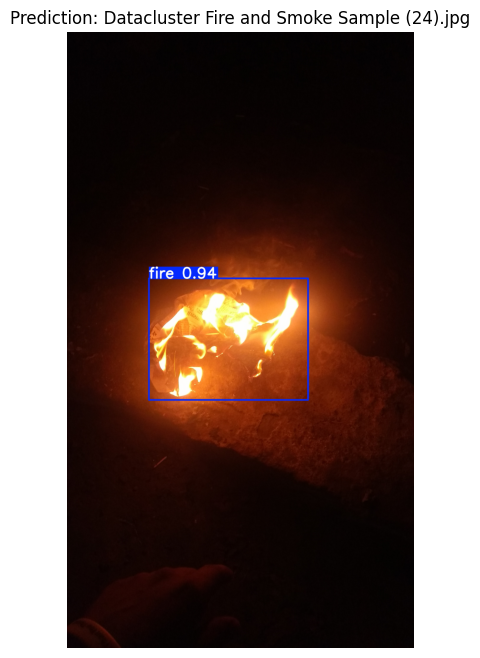

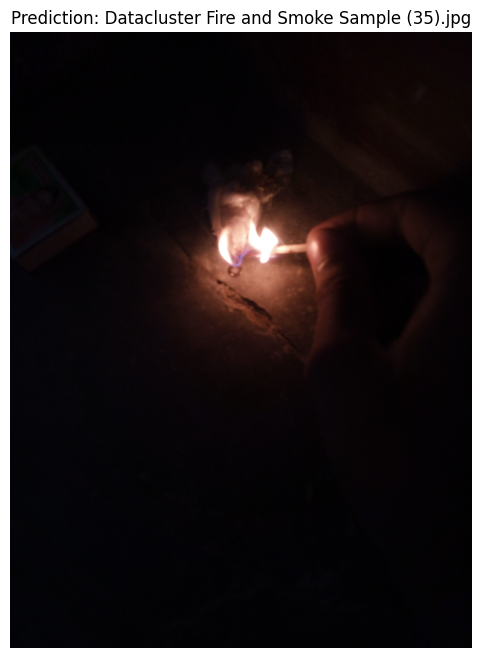

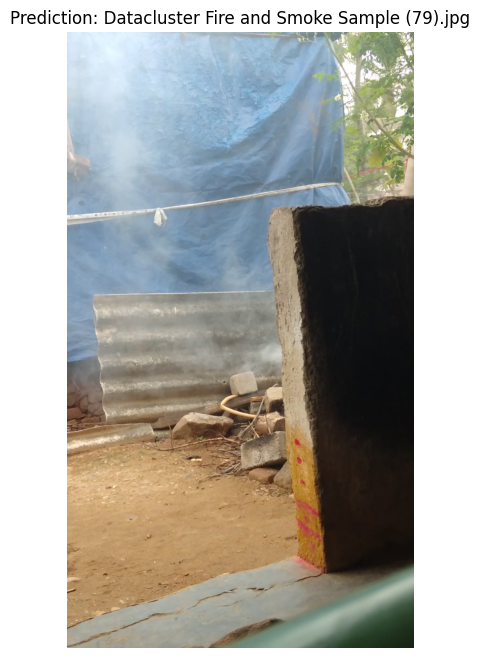

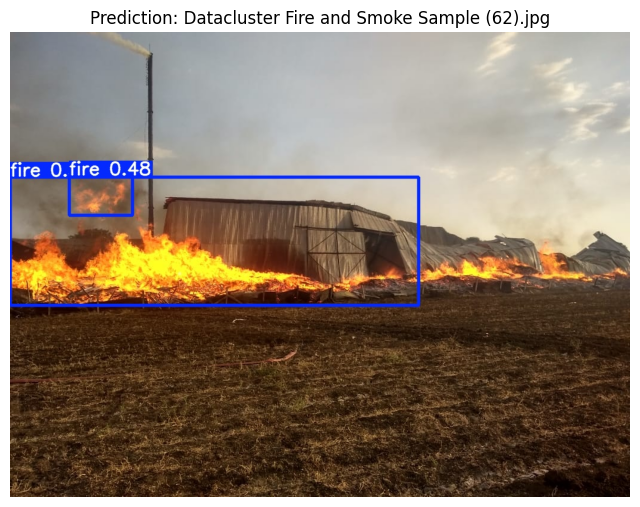

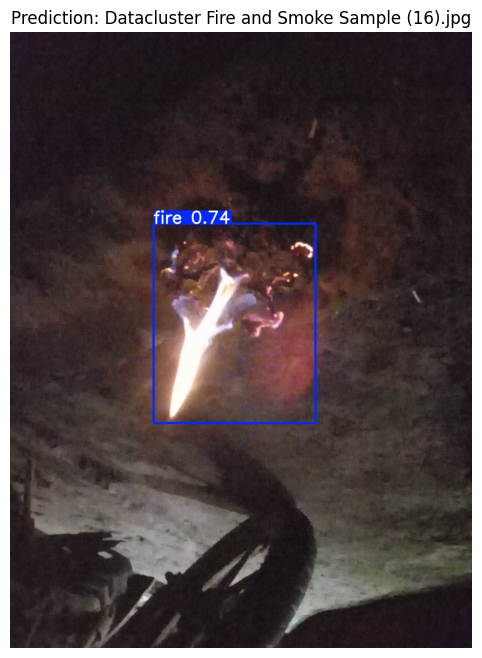

In [11]:
import cv2
import matplotlib.pyplot as plt
pred_folder = "/kaggle/working/runs/detect/train2"  # predicted images path
pred_images = os.listdir(pred_folder)

# Plot the first 5 predictions
for img_name in pred_images[:5]:
    img_path = os.path.join(pred_folder, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {img_name}")
    plt.axis('off')
    plt.show()

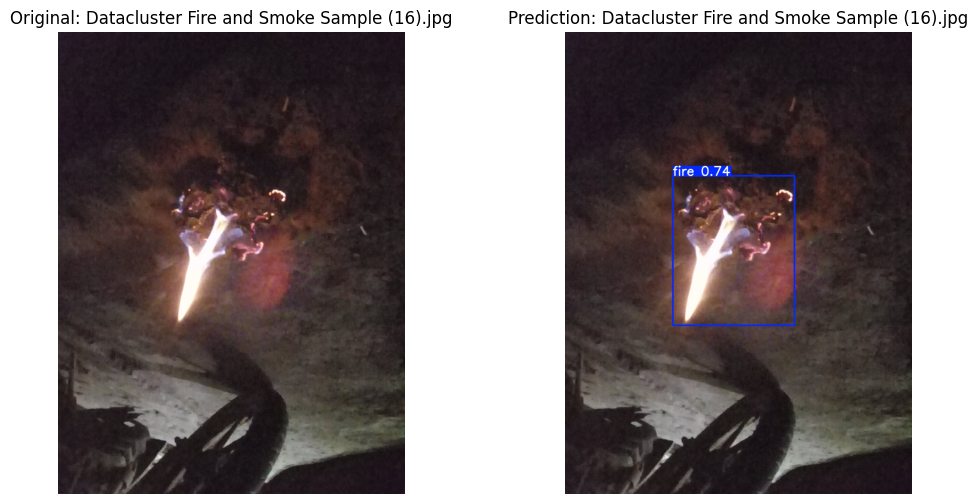

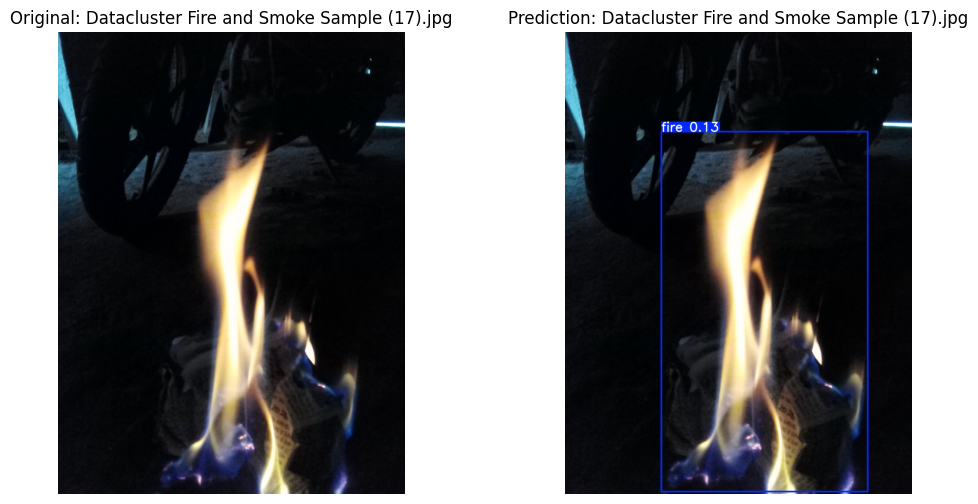

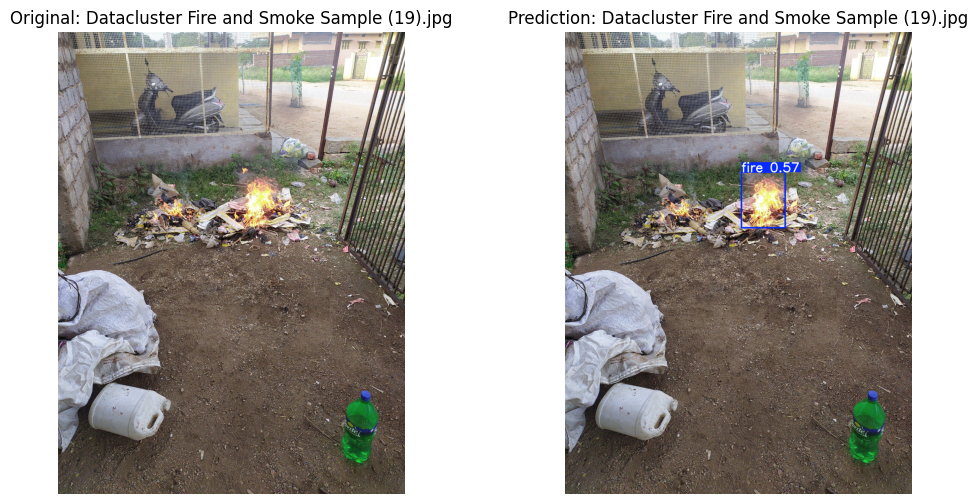

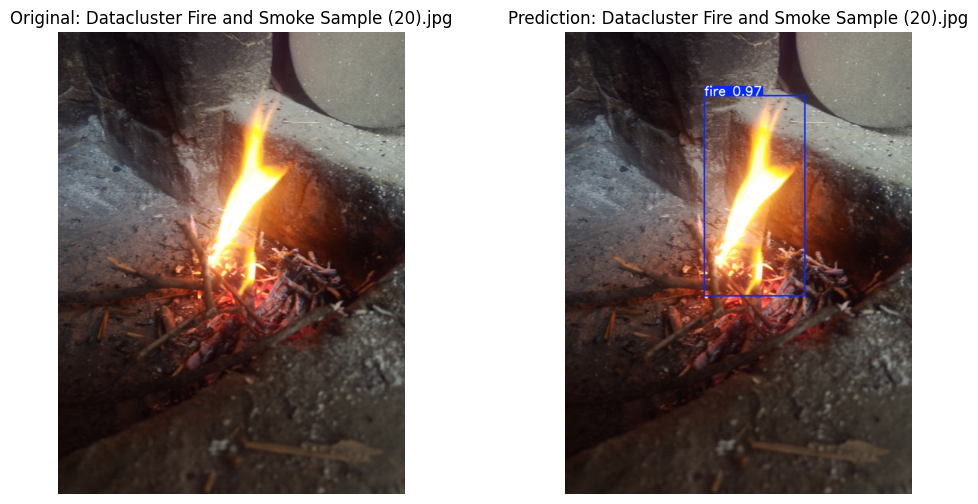

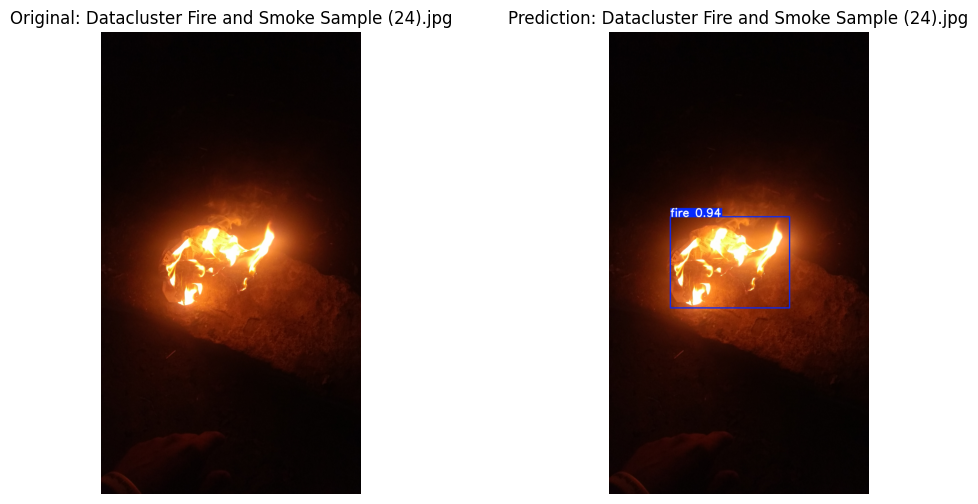

In [12]:
import matplotlib.pyplot as plt
import cv2
import os

# Define directories
val_image_dir = '/kaggle/working/yolo_dataset/images/val'
pred_folder = "/kaggle/working/runs/detect/train2" # YOLO's prediction save path

# Match original and predicted images
original_images = sorted([f for f in os.listdir(val_image_dir) if f.endswith(('.jpg', '.png'))])
predicted_images = sorted([f for f in os.listdir(pred_folder) if f.endswith(('.jpg', '.png'))])

# Display side-by-side for the first 5 images
for orig_name, pred_name in zip(original_images[:5], predicted_images[:5]):
    orig_path = os.path.join(val_image_dir, orig_name)
    pred_path = os.path.join(pred_folder, pred_name)
    
    orig_img = cv2.imread(orig_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    pred_img = cv2.imread(pred_path)
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    # Plot side-by-side
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title(f'Original: {orig_name}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    plt.title(f'Prediction: {pred_name}')
    plt.axis('off')

    plt.show()
